# Exploration

In [1]:
import pandas as pd


data_path = '../data/ApexHub_Deliveries.xlsx'
excel_file = pd.ExcelFile(data_path)
print(excel_file.sheet_names)


['Distribution Center Location ', 'Delivery Addresses', 'Servicable Zipcode']


In [2]:
df_dc = pd.read_excel(data_path, sheet_name='Distribution Center Location ')
df_addr = pd.read_excel(data_path, sheet_name='Delivery Addresses')
df_zip = pd.read_excel(data_path, sheet_name='Servicable Zipcode')


In [3]:
df_dc

,DC Hub Name,Hub Coordinates
0,Apex Hub,"17.235389854, 78.416028660"


In [4]:
df_addr

,ID,hubId,address,pinCode,coordinates,fid
0,1,3,"VENKATARANANA MOTORS, KONDAPUR VILLAGE, HYDERA...",500084,"{""lat"":17.4426289,""lng"":78.3630084}",58897186913
1,2,3,"CTRLS Datacenters Ltd, Nanakramguda, Hyderabad...",500032,"{""lat"":17.4233287,""lng"":78.3303868}",58912701702
2,3,3,"T-HUB FOUNDATION, RAIDURGAM, HYDERABAD, 500081",500081,"{""lat"":17.434079,""lng"":78.378788}",58150388192
3,4,3,"SANGEETHA MOBILES, MAIN ROAD, PILAPNO C-122, M...",500081,"{""lat"":17.3737353,""lng"":78.5371694}",58150367671
4,5,3,"SANGEETHA Mobiles, HYDERABAD, 500081",500001,"{""lat"":17.3683903,""lng"":78.57637150000001}",58150367671
...,...,...,...,...,...,...
64,65,3,"CONQUER CARE TECHNOLOGIES LLP, ACCORD BLEU, KA...",500033,"{""lat"":17.4459763,""lng"":78.3976489}",589019037771
65,66,3,"PREMIUM LIFESTYLE, SHOP NO66-69 UG FLOOR, KOTH...",500084,"{""lat"":17.457948,""lng"":78.36360069999999}",58901903745
66,67,3,"RAYMOND LIMITED, INORBIT MALL, HYDERABAD, 500081",500081,"{""lat"":17.4389049,""lng"":78.389127}",58150329333
67,68,3,"TEJASWI AUTOMOBILES, OPP CYBER TOWER, KPHB ROA...",500081,"{""lat"":17.4535535,""lng"":78.3833446}",58897183903


In [5]:
df_zip

,ZipCode,Unnamed: 1,Unnamed: 2
0,500084,NaN,These are the servicable Zipcodes to be delive...
1,500032,NaN,NaN
2,500081,NaN,NaN
3,500001,NaN,NaN
4,500033,NaN,NaN
5,560066,NaN,NaN


In [32]:
import pandas as pd
import ast

# If you haven't loaded the dataframes yet, do so:
# df_dc = pd.read_excel('../data/ApexHub_Deliveries.xlsx', sheet_name='Distribution Center Location ')
# df_addr = pd.read_excel('../data/ApexHub_Deliveries.xlsx', sheet_name='Delivery Addresses')
# df_zip = pd.read_excel('../data/ApexHub_Deliveries.xlsx', sheet_name='Servicable Zipcode')

# Parse the coordinates column in delivery addresses
def extract_lat(row):
    try:
        return ast.literal_eval(row)['lat']
    except:
        return None

def extract_lng(row):
    try:
        return ast.literal_eval(row)['lng']
    except:
        return None

df_addr['lat'] = df_addr['coordinates'].apply(extract_lat)
df_addr['lng'] = df_addr['coordinates'].apply(extract_lng)

hub_lat, hub_lng = map(float, df_dc['Hub Coordinates'][0].split(','))

serviceable_zipcodes = df_zip['ZipCode'].astype(str).tolist()
df_serviceable = df_addr[df_addr['pinCode'].astype(str).isin(serviceable_zipcodes)]


In [7]:
all(df_addr == df_serviceable)

True

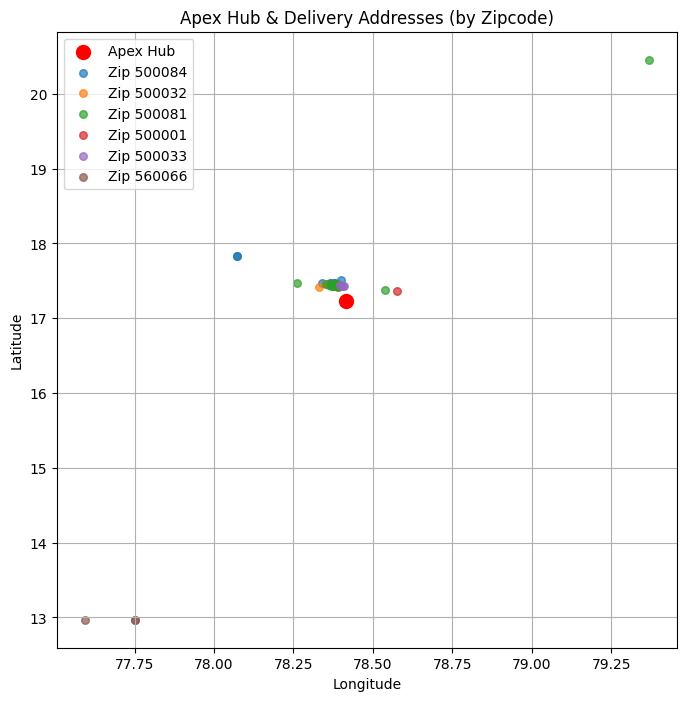

In [34]:
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))

# Plot hub
ax.scatter(hub_lng, hub_lat, color='red', s=100, label='Apex Hub', zorder=3)

# Plot all serviceable delivery addresses, coloring by zipcode
zip_colors = {
    z: color for z, color in zip(serviceable_zipcodes, plt.cm.tab10.colors)
}
for zc in serviceable_zipcodes:
    zc_df = df_serviceable[df_serviceable['pinCode'].astype(str) == zc]
    ax.scatter(
        zc_df['lng'], zc_df['lat'],
        color=zip_colors[zc],
        label=f'Zip {zc}',
        alpha=0.7,
        s=30
    )

ax.set_title("Apex Hub & Delivery Addresses (by Zipcode)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
ax.grid(True)
plt.show()


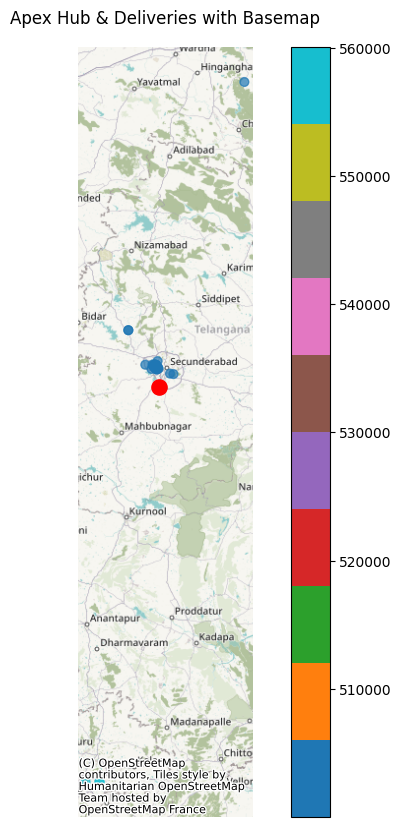

In [35]:
import geopandas as gpd
import contextily as ctx

# Build GeoDataFrame for delivery addresses
gdf_deliveries = gpd.GeoDataFrame(
    df_serviceable,
    geometry=gpd.points_from_xy(df_serviceable['lng'], df_serviceable['lat']),
    crs='EPSG:4326'
)
# Project to Web Mercator for contextily
gdf_deliveries = gdf_deliveries.to_crs(epsg=3857)

# Hub as a GeoDataFrame
hub_gdf = gpd.GeoDataFrame(
    {'geometry': [gpd.points_from_xy([hub_lng], [hub_lat])[0]]},
    crs='EPSG:4326'
).to_crs(epsg=3857)

ax = gdf_deliveries.plot(
    figsize=(10, 10),
    alpha=0.7,
    column='pinCode',
    legend=True,
    cmap='tab10',
    markersize=40
)
hub_gdf.plot(ax=ax, color='red', markersize=120, label='Apex Hub')
ctx.add_basemap(ax)
ax.set_axis_off()
plt.title("Apex Hub & Deliveries with Basemap")
plt.show()


In [36]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="apexhub_geocoder")

# Example for the hub:
location = geolocator.reverse(f"{hub_lat}, {hub_lng}")
print(location.address)

# For a random delivery:
sample_row = df_serviceable.iloc[0]
location2 = geolocator.reverse(f"{sample_row['lat']}, {sample_row['lng']}")
print(location2.address)


Subcentre Peddagollapally, Airport Approach Road, Shamshabad mandal, Balapur mandal, Ranga Reddy, Telangana, 509218, India
Venkateshwara Tata Motors, Gachibowli - Miyapur Highway, J V Colony, Ward 104 Kondapur, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Serilingampalle mandal, Ranga Reddy, Telangana, 500032, India


# Outliers

In [37]:
from geopy.distance import geodesic

hub_coords = (hub_lat, hub_lng)
df_serviceable['distance_from_hub_km'] = df_serviceable.apply(
    lambda row: geodesic(hub_coords, (row['lat'], row['lng'])).km, axis=1
)

# Find distant points (tweak the threshold as you wish)
far_points = df_serviceable[df_serviceable['distance_from_hub_km'] > 50]
print(far_points[['address', 'pinCode', 'lat', 'lng', 'distance_from_hub_km']])

df_serviceable.to_csv("../data/serviceable_deliveries.csv", index=False)


                                              address  pinCode        lat  \
6                                            F949+FCV   500081  20.456238   
26     CHATURBHUJA HOMES, KONDAPUR, HYDERABAD, 500084   500084  17.836061   
27  CHATURBHUJA HOMES,jubille gardens,KONDAPUR, HY...   500084  17.836061   
36  RmZ NeXity, Raidurgam, Panmaqtha Village, Whit...   560066  12.969820   
46  KRC Tower, Commerzone SEZ, Sustain Properties ...   560066  12.971599   
47  Qualcomm India Private Limited- SEZ Unit, Comm...   560066  12.969820   

          lng  distance_from_hub_km  
6   79.368547            370.375390  
26  78.071732             75.867713  
27  78.071732             75.867713  
36  77.749972            477.382943  
46  77.594563            479.977731  
47  77.749972            477.382943  


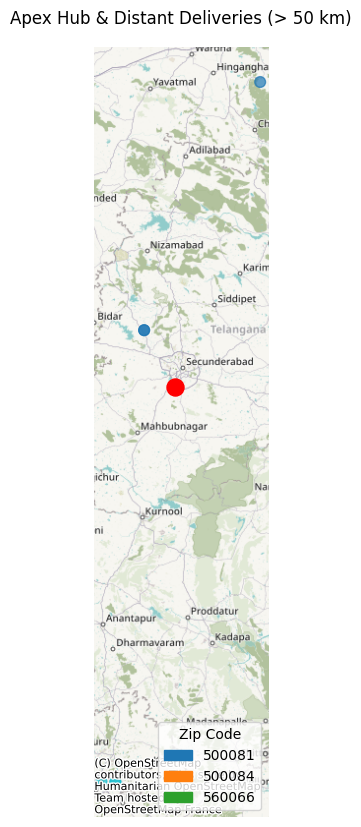

In [38]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx

# Filter for far points
distance_threshold_km = 50
far_points = df_serviceable[df_serviceable['distance_from_hub_km'] > distance_threshold_km]

# GeoDataFrame for far points
gdf_far = gpd.GeoDataFrame(
    far_points,
    geometry=gpd.points_from_xy(far_points['lng'], far_points['lat']),
    crs='EPSG:4326'
).to_crs(epsg=3857)

# GeoDataFrame for hub
hub_gdf = gpd.GeoDataFrame(
    {'geometry': [gpd.points_from_xy([hub_lng], [hub_lat])[0]]},
    crs='EPSG:4326'
).to_crs(epsg=3857)

# Plot
ax = gdf_far.plot(
    figsize=(10, 10),
    alpha=0.7,
    column='pinCode',
    cmap='tab10',
    markersize=60,
    legend=False
)
hub_gdf.plot(ax=ax, color='red', markersize=150, label='Apex Hub')
ctx.add_basemap(ax)
ax.set_axis_off()

# Custom legend for zip codes
colors = plt.cm.tab10.colors
unique_zips = sorted(gdf_far['pinCode'].unique())
patches = [mpatches.Patch(color=colors[i % len(colors)], label=str(zc)) for i, zc in enumerate(unique_zips)]
plt.legend(handles=patches, title="Zip Code", loc="lower right")

plt.title(f"Apex Hub & Distant Deliveries (> {distance_threshold_km} km)")
plt.show()


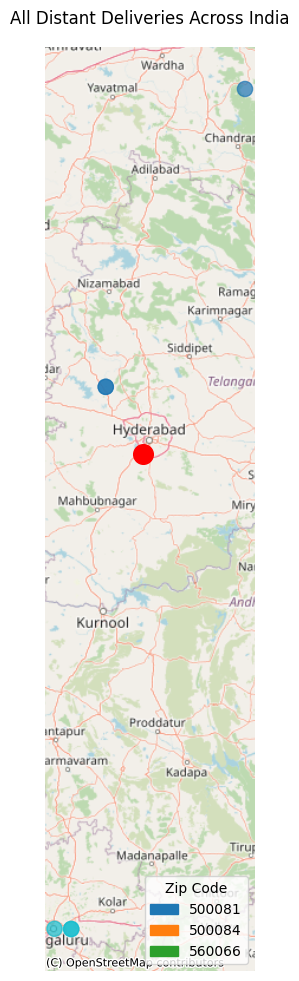

In [39]:
import matplotlib.pyplot as plt

ax = gdf_far.plot(
    figsize=(8, 12),
    alpha=0.7,
    column='pinCode',
    cmap='tab10',
    markersize=120,
    legend=False
)
hub_gdf.plot(ax=ax, color='red', markersize=200, label='Apex Hub')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
colors = plt.cm.tab10.colors
unique_zips = sorted(gdf_far['pinCode'].unique())
patches = [mpatches.Patch(color=colors[i % len(colors)], label=str(zc)) for i, zc in enumerate(unique_zips)]
plt.legend(handles=patches, title="Zip Code", loc="lower right")
plt.title("All Distant Deliveries Across India")
plt.show()


# Nearby Points

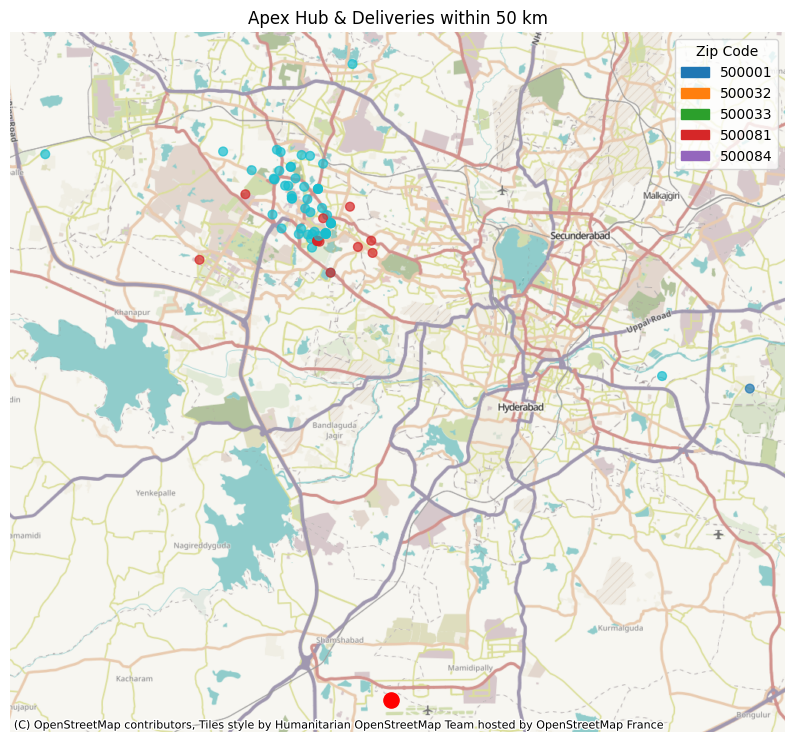

In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import contextily as ctx

# Set your distance threshold as a variable
distance_threshold_km = 50

# Filter by distance from hub
nearby = df_serviceable[df_serviceable['distance_from_hub_km'] <= distance_threshold_km]

# 1. Make GeoDataFrame
gdf_nearby = gpd.GeoDataFrame(
    nearby,
    geometry=gpd.points_from_xy(nearby['lng'], nearby['lat']),
    crs='EPSG:4326'
)
# 2. Project to Web Mercator
gdf_nearby = gdf_nearby.to_crs(epsg=3857)

# 3. Apex Hub as GeoDataFrame
hub_gdf = gpd.GeoDataFrame(
    {'geometry': [gpd.points_from_xy([hub_lng], [hub_lat])[0]]},
    crs='EPSG:4326'
).to_crs(epsg=3857)

# 4. Plot
ax = gdf_nearby.plot(
    figsize=(10, 10),
    alpha=0.7,
    column='pinCode',
    cmap='tab10',
    markersize=40
)
hub_gdf.plot(ax=ax, color='red', markersize=120, label='Apex Hub')

ctx.add_basemap(ax) # source=cts.providers.CartoDB.Positron
ax.set_axis_off()

# Custom legend for zip codes
colors = plt.cm.tab10.colors
unique_zips = sorted(gdf_nearby['pinCode'].unique())
patches = [mpatches.Patch(color=colors[i % len(colors)], label=str(zc)) for i, zc in enumerate(unique_zips)]
plt.legend(handles=patches, title="Zip Code", loc="upper right")

# Title with dynamic threshold
plt.title(f"Apex Hub & Deliveries within {distance_threshold_km} km")
plt.show()


In [41]:
print(df_serviceable[df_serviceable['pinCode'] == 560066][['address', 'lat', 'lng', 'distance_from_hub_km']])


                                              address        lat        lng  \
36  RmZ NeXity, Raidurgam, Panmaqtha Village, Whit...  12.969820  77.749972   
46  KRC Tower, Commerzone SEZ, Sustain Properties ...  12.971599  77.594563   
47  Qualcomm India Private Limited- SEZ Unit, Comm...  12.969820  77.749972   

    distance_from_hub_km  
36            477.382943  
46            479.977731  
47            477.382943  


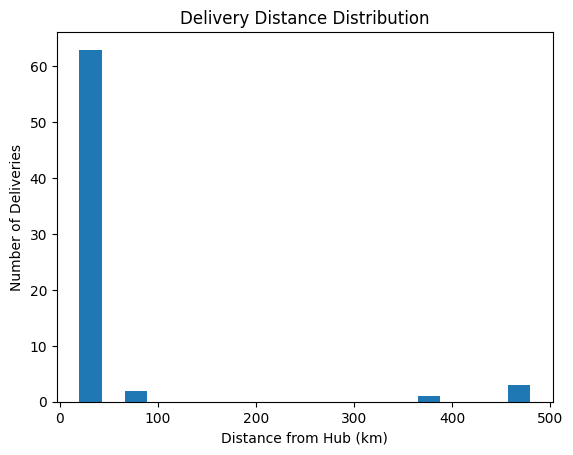

In [42]:
import matplotlib.pyplot as plt

plt.hist(df_serviceable['distance_from_hub_km'], bins=20)
plt.xlabel('Distance from Hub (km)')
plt.ylabel('Number of Deliveries')
plt.title('Delivery Distance Distribution')
plt.show()


# Distance Percentiles (Coverage)

In [43]:
import numpy as np

# Get distances
distances = df_serviceable['distance_from_hub_km'].values

# Choose percentiles of interest (e.g. 50, 80, 90, 95, 99)
percentiles = [50, 80, 90, 95, 99, 100]
percentile_values = np.percentile(distances, percentiles)

for p, val in zip(percentiles, percentile_values):
    print(f"{p}% of deliveries are within {val:.1f} km of the hub.")


50% of deliveries are within 23.5 km of the hub.
80% of deliveries are within 25.7 km of the hub.
90% of deliveries are within 30.2 km of the hub.
95% of deliveries are within 252.6 km of the hub.
99% of deliveries are within 478.2 km of the hub.
100% of deliveries are within 480.0 km of the hub.


In [44]:
import numpy as np
import pandas as pd

distances = df_serviceable['distance_from_hub_km'].values
N_total = len(distances)
percentiles = [50, 80, 90, 95, 99, 100]
percentile_values = np.percentile(distances, percentiles)

summary = []

for p, val in zip(percentiles, percentile_values):
    count = np.sum(distances <= val)
    summary.append({
        'Percentile': p,
        'Distance_km': round(val, 1),
        'Deliveries_Covered': count,
        'Percent_Covered': round(count / N_total * 100, 1)
    })

df_percentile = pd.DataFrame(summary)
print(df_percentile)


   Percentile  Distance_km  Deliveries_Covered  Percent_Covered
0          50         23.5                  35             50.7
1          80         25.7                  55             79.7
2          90         30.2                  62             89.9
3          95        252.6                  65             94.2
4          99        478.2                  68             98.6
5         100        480.0                  69            100.0


In [23]:
print("Service Radius Coverage Analysis\n")
for idx, row in df_percentile.iterrows():
    pct = int(row['Percentile'])
    dist = row['Distance_km']
    n = int(row['Deliveries_Covered'])
    if pct == 100:
        print(f"  {pct}% within {dist} km ({n} addresses, including extreme outliers).")
    else:
        print(f"  {pct}% of deliveries are within {dist} km of the hub ({n} addresses).")

print("\nRecommendation: Focus standard routing within a 30 km radius for daily operations, "
      "and handle distant outliers (>100 km) with a separate process.")


Service Radius Coverage Analysis

  50% of deliveries are within 23.5 km of the hub (35 addresses).
  80% of deliveries are within 25.7 km of the hub (55 addresses).
  90% of deliveries are within 30.2 km of the hub (62 addresses).
  95% of deliveries are within 252.6 km of the hub (65 addresses).
  99% of deliveries are within 478.2 km of the hub (68 addresses).
  100% within 480.0 km (69 addresses, including extreme outliers).

Recommendation: Focus standard routing within a 30 km radius for daily operations, and handle distant outliers (>100 km) with a separate process.


# Duplicates

In [45]:
duplicates_coords = df_serviceable[df_serviceable.duplicated(subset=['lat', 'lng', 'pinCode'], keep=False)]
print(f"Duplicate locations (same lat/lng & pin code): {len(duplicates_coords)}")
if not duplicates_coords.empty:
    display(duplicates_coords.sort_values(['lat', 'lng', 'pinCode']))


Duplicate locations (same lat/lng & pin code): 21


,ID,hubId,address,pinCode,coordinates,fid,lat,lng,distance_from_hub_km
36,37,3,"RmZ NeXity, Raidurgam, Panmaqtha Village, Whit...",560066,"{""lat"":12.9698196,""lng"":77.7499721}",58150350182,12.969820,77.749972,477.382943
47,48,3,"Qualcomm India Private Limited- SEZ Unit, Comm...",560066,"{""lat"":12.9698196,""lng"":77.7499721}",58909070080,12.969820,77.749972,477.382943
38,39,3,"RMZ Nexity, Hyderabad Knowledge City Layout, R...",500032,"{""lat"":17.431393,""lng"":78.38305199999999}",58150350182,17.431393,78.383052,21.973624
39,40,3,"RMZ Nexity, Hyderabad Knowledge City Layout, R...",500032,"{""lat"":17.431393,""lng"":78.38305199999999}",58150350182,17.431393,78.383052,21.973624
40,41,3,"RMZ Nexity, Hyderabad Knowledge City Layout, R...",500032,"{""lat"":17.431393,""lng"":78.38305199999999}",58150350182,17.431393,78.383052,21.973624
41,42,3,"RMZ Nexity, Hyderabad Knowledge City Layout, R...",500032,"{""lat"":17.431393,""lng"":78.38305199999999}",58150350182,17.431393,78.383052,21.973624
19,20,3,"FCM Travel Solution India ,New Software Units ...",500081,"{""lat"":17.4343868,""lng"":78.3869095}",58047458221,17.434387,78.386910,22.240013
32,33,3,"CTRLS Datacenters Ltd, Pioneer Towers, Softwar...",500081,"{""lat"":17.4343868,""lng"":78.3869095}",58912701691,17.434387,78.386910,22.240013
44,45,3,"Pennywise Solutions Private Limited, First Flo...",500081,"{""lat"":17.4343868,""lng"":78.3869095}",58150305964,17.434387,78.386910,22.240013
13,14,3,"INORBIT MALL, HI-TECH CITY, HYDERABAD, 500081",500081,"{""lat"":17.4389049,""lng"":78.389127}",58150327351,17.438905,78.389127,22.704396


In [46]:
# Find all records with duplicate (lat, lng) pairs
duplicates_coords = df_serviceable[df_serviceable.duplicated(subset=['lat', 'lng'], keep=False)]
print(f"Number of addresses with duplicate coordinates: {len(duplicates_coords)}")
if not duplicates_coords.empty:
    display(duplicates_coords.sort_values(['lat', 'lng']))


Number of addresses with duplicate coordinates: 23


,ID,hubId,address,pinCode,coordinates,fid,lat,lng,distance_from_hub_km
36,37,3,"RmZ NeXity, Raidurgam, Panmaqtha Village, Whit...",560066,"{""lat"":12.9698196,""lng"":77.7499721}",58150350182,12.969820,77.749972,477.382943
47,48,3,"Qualcomm India Private Limited- SEZ Unit, Comm...",560066,"{""lat"":12.9698196,""lng"":77.7499721}",58909070080,12.969820,77.749972,477.382943
11,12,3,"Qualcomm India Pvt Ltd, KRC Tower, Commerzone ...",500081,"{""lat"":17.4178301,""lng"":78.3889717}",58150337501,17.417830,78.388972,20.394997
37,38,3,"Hyderabad Knowledge Ltd, Raidurgam Panmaqtha V...",500032,"{""lat"":17.4178301,""lng"":78.3889717}",58150350182,17.417830,78.388972,20.394997
38,39,3,"RMZ Nexity, Hyderabad Knowledge City Layout, R...",500032,"{""lat"":17.431393,""lng"":78.38305199999999}",58150350182,17.431393,78.383052,21.973624
39,40,3,"RMZ Nexity, Hyderabad Knowledge City Layout, R...",500032,"{""lat"":17.431393,""lng"":78.38305199999999}",58150350182,17.431393,78.383052,21.973624
40,41,3,"RMZ Nexity, Hyderabad Knowledge City Layout, R...",500032,"{""lat"":17.431393,""lng"":78.38305199999999}",58150350182,17.431393,78.383052,21.973624
41,42,3,"RMZ Nexity, Hyderabad Knowledge City Layout, R...",500032,"{""lat"":17.431393,""lng"":78.38305199999999}",58150350182,17.431393,78.383052,21.973624
19,20,3,"FCM Travel Solution India ,New Software Units ...",500081,"{""lat"":17.4343868,""lng"":78.3869095}",58047458221,17.434387,78.386910,22.240013
32,33,3,"CTRLS Datacenters Ltd, Pioneer Towers, Softwar...",500081,"{""lat"":17.4343868,""lng"":78.3869095}",58912701691,17.434387,78.386910,22.240013


In [47]:
grouped_coords = df_serviceable.groupby(['lat', 'lng']).size().reset_index(name='num_deliveries')
# Only keep those with more than 1 delivery (i.e., duplicates)
duplicates_grouped = grouped_coords[grouped_coords['num_deliveries'] > 1]
print(f"Number of unique locations with multiple deliveries: {len(duplicates_grouped)}")
display(duplicates_grouped)


Number of unique locations with multiple deliveries: 9


,lat,lng,num_deliveries
0,12.969820,77.749972,2
4,17.417830,78.388972,2
10,17.431393,78.383052,4
17,17.434387,78.386910,3
23,17.438905,78.389127,3
32,17.449452,78.371699,2
35,17.453554,78.383345,3
44,17.462950,78.371182,2
53,17.836061,78.071732,2


In [48]:
duplicates_address = df_serviceable[df_serviceable.duplicated(subset=['address'], keep=False)]
print(f"Duplicate address strings: {len(duplicates_address)}")
if not duplicates_address.empty:
    display(duplicates_address.sort_values(['address']))


Duplicate address strings: 10


,ID,hubId,address,pinCode,coordinates,fid,lat,lng,distance_from_hub_km
28,29,3,"CHATURBHUJA HOMES, JUBILEE GARDENS, KONDAPUR, ...",500084,"{""lat"":17.4629499,""lng"":78.3711819}",58931508613,17.462950,78.371182,25.631880
29,30,3,"CHATURBHUJA HOMES, JUBILEE GARDENS, KONDAPUR, ...",500084,"{""lat"":17.4629499,""lng"":78.3711819}",58931508613,17.462950,78.371182,25.631880
13,14,3,"INORBIT MALL, HI-TECH CITY, HYDERABAD, 500081",500081,"{""lat"":17.4389049,""lng"":78.389127}",58150327351,17.438905,78.389127,22.704396
14,15,3,"INORBIT MALL, HI-TECH CITY, HYDERABAD, 500081",500081,"{""lat"":17.4389049,""lng"":78.389127}",58150327351,17.438905,78.389127,22.704396
38,39,3,"RMZ Nexity, Hyderabad Knowledge City Layout, R...",500032,"{""lat"":17.431393,""lng"":78.38305199999999}",58150350182,17.431393,78.383052,21.973624
39,40,3,"RMZ Nexity, Hyderabad Knowledge City Layout, R...",500032,"{""lat"":17.431393,""lng"":78.38305199999999}",58150350182,17.431393,78.383052,21.973624
40,41,3,"RMZ Nexity, Hyderabad Knowledge City Layout, R...",500032,"{""lat"":17.431393,""lng"":78.38305199999999}",58150350182,17.431393,78.383052,21.973624
41,42,3,"RMZ Nexity, Hyderabad Knowledge City Layout, R...",500032,"{""lat"":17.431393,""lng"":78.38305199999999}",58150350182,17.431393,78.383052,21.973624
50,51,3,"TEJASWI AUTOMOBILES, OPP CYBER TOWER, KPHB ROA...",500081,"{""lat"":17.4535535,""lng"":78.3833446}",58897185852,17.453554,78.383345,24.393469
67,68,3,"TEJASWI AUTOMOBILES, OPP CYBER TOWER, KPHB ROA...",500081,"{""lat"":17.4535535,""lng"":78.3833446}",58897183903,17.453554,78.383345,24.393469


In [49]:
import pandas as pd

summary_table = pd.DataFrame({
    "Metric": [
        "Duplicate locations (lat/lng & pin code)",
        "Addresses with duplicate coordinates",
        "Unique locations with multiple deliveries",
        "Duplicate address strings"
    ],
    "Value": [21, 23, 9, 10]
})

print(summary_table)


                                      Metric  Value
0   Duplicate locations (lat/lng & pin code)     21
1       Addresses with duplicate coordinates     23
2  Unique locations with multiple deliveries      9
3                  Duplicate address strings     10
